# Building an Agent using LangGraph

LangGraph enables you to define and manage complex, cyclical workflows. Its built-in memory is essential for handling simultaneous conversations, recalling past interactions, and allowing for human intervention.

Think of LangGraph as a director for your application's workflow. It allows you to create complex sequences of actions, even ones that loop back on themselves. Critically, it has a built-in memory, which is perfect for keeping track of multiple different conversations at once or remembering what happened earlier, making it possible for a human to step in and guide the process.

LangGraph are nodes, edges and conditional edges

## LangChain: Tools

Let's review one of the LangChain's components. What's tool calling in LangChain?  

Per LangChain's doc: ***"The tool abstraction in LangChain associates a Python function with a schema that defines the function's name, description and expected arguments."***

The recommended way to create tools is using the `@tool` decorator. 

````
from langchain_core.tools import tool

@tool
def exponentiate(x: float, y: float) -> float:
    """Raise 'x' to the 'y'."""
    return x**y
```

Here is my understanding of tool calling: 

**A Bridge for Action:** It's precisely a bridge between the language model and the outside world. This allows the model to move beyond just generating text and actually perform actions.

**A Defined Function:** At its core, a tool is a function with a specific purpose, whether that's looking up information, running a calculation, or sending an email.

**Crucial Metadata:** The name, description, and input schema are vital. The model relies heavily on the description to understand what the tool does and when it should be used.

 

In [1]:
from dotenv import load_dotenv
_ = load_dotenv()

In [ ]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [3]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [4]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [5]:
class Agent:
    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_llm )
        graph.add_node("action", self.take_action)
        # # It checks whether there is an action present
        # # If there is then it goes to the action node.
        # The third argument is a dictionary representing how to map the response of the function to the next node to go to.
        # # if exists_action returns True, go to action node
        graph.add_conditional_edges(
            "llm",  # the node where the edge starts
            self.exists_action,  # where to go next based on the state of the agent
            { True: "action", False: END }  # if exists_action returns False, go to END node
        )
        graph.add_edge("action", "llm")  # Start the graph by calling the LLM
        graph.set_entry_point("llm")
        self.graph = graph.compile() # A LangChain runnable exposes a standard interface for calling and invoking this graph.
        self.tools = { t.name: t for t in tools }
        # print(f'tools => {self.tools}')
        self.model = model.bind_tools(tools) #tools available to call.


    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0
    
    def call_llm(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return { 'messages': [ message]}
    
    def take_action(self, state: AgentState):
        print('state["messages"] => ', state["messages"])
        tool_calls = state["messages"][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [6]:
tool = TavilySearchResults(max_results=4) #increased number of results
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot =Agent(model, [tool], system=prompt)


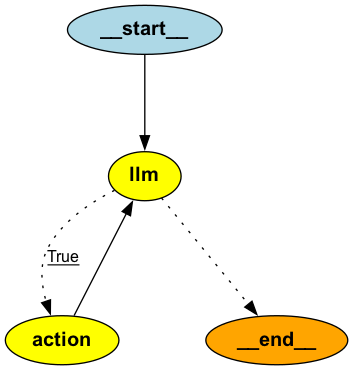

In [7]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [8]:
messages = [HumanMessage(content="Where is the capital of Asunción located?")]
result = abot.graph.invoke({"messages": messages})

state["messages"] =>  [HumanMessage(content='Where is the capital of Asunción located?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_u1fN24trFEFiQl4ionCN4Flv', 'function': {'arguments': '{"query":"capital of Asunción"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 156, 'total_tokens': 178, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BqV7VRxVMwWe7rtz9YbFhqLj9Rkyl', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-202b7438-b66f-47c8-8f76-e3eb6e575cb6-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'capital of Asunción'}, 'id': 'call_u1fN2

In [9]:
result['messages'][-1].content

'The capital of Asunción is the largest city of Paraguay. It stands on the eastern bank of the Paraguay River, almost at the confluence of the Paraguay River with the Pilcomayo River. You can find more information on Wikipedia: [Asunción - Wikipedia](https://en.wikipedia.org/wiki/Asunci%C3%B3n).'

In [10]:
messages = [HumanMessage(content="Which countries are in the same timezone as Asunción?")]
result = abot.graph.invoke({"messages": messages})

state["messages"] =>  [HumanMessage(content='Which countries are in the same timezone as Asunción?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Ej8X0eRXADABkxA2ffWJ8f1Z', 'function': {'arguments': '{"query":"countries in the same timezone as Asunción"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 158, 'total_tokens': 184, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BqV92e44QFA4mhqqpm6tRaCRqJlwo', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a8786e55-acac-4fcc-9f5a-86bbb27ce93a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'count

In [11]:
result['messages'][-1].content

'The countries that are in the same timezone as Asunción, Paraguay (which is in the America/Asuncion timezone) include:\n\n1. Paraguay (Asunción)\n2. Puerto Rico (San Juan)\n3. Chile (Santiago)\n4. Argentina (Buenos Aires)\n\nThese countries are in the UTC-4 timezone.'

In [12]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Did Paraguay classify to FIFA World Cup 2022? Did Argentina qualify as well?. Answer each question." 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

state["messages"] =>  [HumanMessage(content='Did Paraguay classify to FIFA World Cup 2022? Did Argentina qualify as well?. Answer each question.', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qZyQ8Zm6Avovf05YEXg1t913', 'function': {'arguments': '{"query": "Paraguay FIFA World Cup 2022 qualification"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_QrYcbjp7ij9h6QgpBsDphadD', 'function': {'arguments': '{"query": "Argentina FIFA World Cup 2022 qualification"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 68, 'prompt_tokens': 165, 'total_tokens': 233, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprin

In [13]:
print(result['messages'][-1].content)

Paraguay did not qualify for the FIFA World Cup 2022. They finished 8th in the CONMEBOL qualification standings.

Argentina, on the other hand, successfully qualified for the FIFA World Cup 2022. They finished 2nd in the CONMEBOL qualification standings.
